# label transfer practice using seurat labeltransfer tools
## label transfer between Brescia acute covid dataset and covid-flu dataset

In [2]:
library(Seurat)
library(matrixStats)
library(plyr)
library(tidyverse)
library(future)
library(future.apply)
plan("multisession", workers = 4)
options(future.globals.maxSize = 20000 * 1024^2)
library(pheatmap)

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject


Attaching package: ‘plyr’


The following object is masked from ‘package:matrixStats’:

    count


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count(), matrixStats::count()
✖ dplyr::desc()      masks plyr::desc()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::fi

In [3]:
datapath = "/gpfs/gibbs/pi/csei/users/CanLiu/projects/pub_datasets/"
getwd()

[1] "/gpfs/gibbs/project/tsang/cl2626/ondemand_data/cell_ann_stat"

In [5]:
acute_covid <- readRDS(paste0(datapath, "Brescia_covid/brescia_paper1_seurat.rds"))
covid_flu <- readRDS(paste0(datapath, "covid_flu/GSE206265_covid_flu.CITEseq.Seurat.obj.RDS"))

In [4]:
# remove some slots to save space
covid_flu@assays$SCT = NULL
acute_covid@assays$CITE <- NULL

In [5]:
# remove the dblt and unknown populations from the acute covid data before transfer
remove = unique(acute_covid$WCTmergedcelltype)[str_detect(unique(acute_covid$WCTmergedcelltype), pattern = "blt|Unknown|gated")]
remove

[1] "gated_out"                  "Unknown_Unknown"           
 [3] "Dblt_B.Tcell.dblt"          "Dblt"                      
 [5] "Mono_Classical_dblt.Mono.T" "Dblt_B.T"                  
 [7] "Unknown"                    "Dblt_T.DC.dblt"            
 [9] "B_Naive_B.Mono.dblt"        "B_Mem_B.T.dblt"            
[11] "Dblt_B.Gran.dblt"           "Dblt_B.T.dblt"             
[13] "Dblt_B.Mono.dblt"

In [6]:
acute_covid = subset(acute_covid, subset = WCTmergedcelltype %in% remove, invert = TRUE)

In [7]:
acute_covid

An object of class Seurat 
32934 features across 397468 samples within 3 assays 
Active assay: RNA (32738 features, 473 variable features)
 2 other assays present: HTO, limmaCITE

## trasnfer using ADT data
### transfer using PCs as anchors

In [8]:
DefaultAssay(acute_covid) = "limmaCITE"
DefaultAssay(covid_flu) = "CITE"

In [9]:
acute_covid

An object of class Seurat 
32934 features across 397468 samples within 3 assays 
Active assay: limmaCITE (192 features, 0 variable features)
 2 other assays present: RNA, HTO

In [10]:
covid_flu

An object of class Seurat 
28543 features across 632100 samples within 3 assays 
Active assay: CITE (138 features, 0 variable features)
 2 other assays present: RNA, HTO
 1 dimensional reduction calculated: adt.umap

In [11]:
rownames(covid_flu)

[1] "PROT-CD29"                  "PROT-CD11a"                
  [3] "PROT-CD44"                  "PROT-HLA-ABC"              
  [5] "PROT-CD18"                  "PROT-CD272"                
  [7] "PROT-CD79b"                 "PROT-CD85j"                
  [9] "PROT-CD45"                  "PROT-CD270"                
 [11] "PROT-CD48"                  "PROT-CD105"                
 [13] "PROT-CD224"                 "PROT-CD101"                
 [15] "PROT-CD82"                  "PROT-CD328"                
 [17] "PROT-IgKLightChain"         "PROT-CD94"                 
 [19] "PROT-CD319"                 "PROT-CD36"                 
 [21] "PROT-CD26"                  "PROT-CD71"                 
 [23] "PROT-CD22"                  "PROT-CD81"                 
 [25] "PROT-CD2"                   "PROT-CD83"                 
 [27] "PROT-CD137"                 "PROT-integrinBeta7"        
 [29] "PROT-CD244"                 "PROT-CD314"                
 [31] "PROT-CD1d"                  "PROT-CD27"                 
 [33] "PROT-CD152"                 "PROT-CD161"                
 [35] "PROT-CD185"                 "PROT-CD195"                
 [37] "PROT-IgM"                   "PROT-CD31"                 
 [39] "PROT-CD335"                 "PROT-CD25"                 
 [41] "PROT-CD16"                  "PROT-CD7"                  
 [43] "PROT-CD56"                  "PROT-CD47"                 
 [45] "PROT-CD112"                 "PROT-CD86"                 
 [47] "PROT-HLA-E"                 "PROT-CD127"                
 [49] "PROT-CD38"                  "PROT-CD119"                
 [51] "PROT-RatIgG1kiso"           "PROT-RatIgG2akiso"         
 [53] "PROT-CD11b"                 "PROT-CD42b"                
 [55] "PROT-ArmenianHamsterIgGiso" "PROT-CD13"                 
 [57] "PROT-CD49a"                 "PROT-CD352"                
 [59] "PROT-GPR56"                 "PROT-CD88"                 
 [61] "PROT-IglightchainLamda"     "PROT-CD23"                 
 [63] "PROT-CLEC12A"               "PROT-CD99"                 
 [65] "PROT-CD158e1"               "PROT-TCRVdelta2"           
 [67] "PROT-TCRValpha7p2"          "PROT-CD73"                 
 [69] "PROT-CD49d"                 "PROT-CD158"                
 [71] "PROT-CD28"                  "PROT-IgD"                  
 [73] "PROT-CD49b"                 "PROT-CD163"                
 [75] "PROT-CD41"                  "PROT-Fc-RI-"               
 [77] "PROT-CD267"                 "PROT-CD122"                
 [79] "PROT-CD62P"                 "PROT-CD268"                
 [81] "PROT-CD21"                  "PROT-CD24"                 
 [83] "PROT-CX3CR1"                "PROT-CD39"                 
 [85] "PROT-CD58"                  "PROT-CD278"                
 [87] "PROT-CD35"                  "PROT-CD141"                
 [89] "PROT-CD64"                  "PROT-CD1c"                 
 [91] "PROT-HLA-DR"                "PROT-CD95"                 
 [93] "PROT-KLRG1"                 "PROT-CD69"                 
 [95] "PROT-CD103"                 "PROT-CD196"                
 [97] "PROT-CD32"                  "PROT-CD146"                
 [99] "PROT-CD20"                  "PROT-RatIgG2bkIso"         
[101] "PROT-IgG2bkiso"             "PROT-IgG2akiso"            
[103] "PROT-IgG1kiso"              "PROT-TIGIT"                
[105] "PROT-CD279"                 "PROT-CD45RO"               
[107] "PROT-CD14"                  "PROT-CD4"                  
[109] "PROT-CD194"                 "PROT-CD123"                
[111] "PROT-CD45RA"                "PROT-CD11c"                
[113] "PROT-CD33"                  "PROT-CD19"                 
[115] "PROT-CD8"                   "PROT-CD3"                  
[117] "PROT-CD154"                 "PROT-CD40"                 
[119] "PROT-CD155"                 "PROT-CD274"                
[121] "PROT-CD183"                 "PROT-CD134"                
[123] "PROT-CD158b"                "PROT-LOX-1"                
[125] "PROT-CD124"                

In [12]:
# rename the features to make them matched between 2 objects
acute_cite_data = acute_covid@assays$limmaCITE@data
rownames(acute_cite_data) = paste("PROT", rownames(acute_cite_data), sep = "-")
rownames(acute_cite_data)[rownames(acute_cite_data) == "PROT-TCRVd2"] <- "PROT-TCRVdelta2"
rownames(acute_cite_data)[rownames(acute_cite_data) == "PROT-TCRVa7.2"] <- "PROT-TCRValpha7p2"

In [13]:
acute_cite_data = acute_cite_data[rownames(acute_cite_data) %in% rownames(covid_flu),]

In [14]:
summary(rownames(acute_cite_data) %in% rownames(covid_flu))

   Mode    TRUE 
logical     115 

In [15]:
acute_covid[["CITE"]] = CreateAssayObject(data = acute_cite_data)

In [16]:
DefaultAssay(acute_covid) = "CITE"
acute_covid@assays$limmaCITE = NULL

In [17]:
acute_covid

An object of class Seurat 
32857 features across 397468 samples within 3 assays 
Active assay: CITE (115 features, 0 variable features)
 2 other assays present: RNA, HTO

In [18]:
covid_flu$batch = covid_flu$Batch

In [19]:
covid_list <- list("acute_covid" = acute_covid, "covid_flu" = covid_flu)

In [20]:
covid_list <- lapply(X = covid_list, FUN = function(x) {
    x <- FindVariableFeatures(x, nfeatures = 100)
})

Warning message in FindVariableFeatures.Assay(object = assay.data, selection.method = selection.method, :
“selection.method set to 'vst' but count slot is empty; will use data slot instead”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of items to replace is not a multiple of replacement length”


In [21]:
features <- SelectIntegrationFeatures(object.list = covid_list)

In [22]:
length(features)

[1] 106

In [23]:
covid_list <- lapply(X = covid_list, FUN = function(x) {
    x <- ScaleData(x, features = features)
    x <- RunPCA(x, features = features)
})

Centering and scaling data matrix

PC_ 1 
Positive:  PROT-CLEC12A, PROT-CD31, PROT-CD36, PROT-CD33, PROT-CD11c, PROT-CD11b, PROT-CD88, PROT-CD14, PROT-CD41, PROT-CD58 
	   PROT-CD39, PROT-CD328, PROT-CD35, PROT-CD64, PROT-CD1d, PROT-CD49b, PROT-CD101, PROT-CD86, PROT-CD155, PROT-CD62P 
	   PROT-CD54, PROT-CD32, PROT-HLA-DR, PROT-CD85j, PROT-CD29, PROT-CD38, PROT-HLA-ABC, PROT-CD107a, PROT-CD69, PROT-CD18 
Negative:  PROT-CD2, PROT-CD5, PROT-CD3, PROT-CD7, PROT-CD28, PROT-CD27, PROT-TCRab, PROT-CD127, PROT-CD278, PROT-CD26 
	   PROT-CD62L, PROT-CD81, PROT-CD4, PROT-CD8, PROT-CD52, PROT-KLRG1, PROT-CD45RA, PROT-CD25, PROT-CD161, PROT-CD194 
	   PROT-CD73, PROT-CD314, PROT-CD94, PROT-TCRValpha7p2, PROT-CD57, PROT-CD146, PROT-IgD, PROT-CD21, PROT-TCRVdelta2, PROT-CD45 
PC_ 2 
Positive:  PROT-CD2, PROT-CD49f, PROT-CD99, PROT-CD45RO, PROT-CD95, PROT-CD5, PROT-CD4, PROT-CD11a, PROT-CD226, PROT-CD18 
	   PROT-CD28, PROT-CD224, PROT-CD127, PROT-CD26, PROT-CD278, PROT-CD3, PROT-CD29, PROT-CD7, P

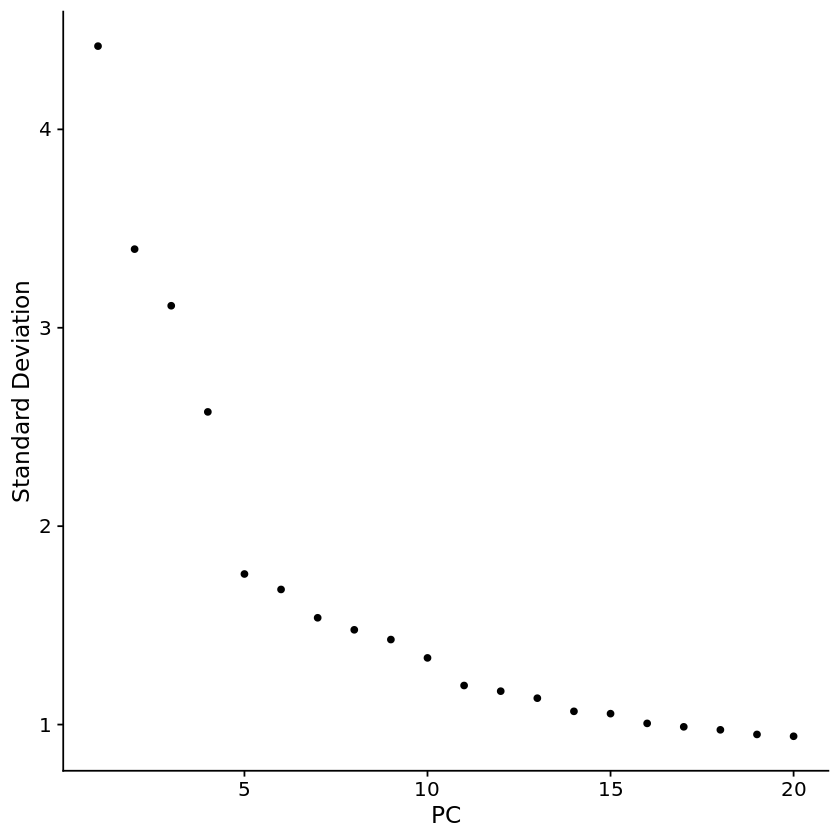

In [24]:
ElbowPlot(covid_list$covid_flu)

In [25]:
covid_list[1]

$acute_covid
An object of class Seurat 
32857 features across 397468 samples within 3 assays 
Active assay: CITE (115 features, 100 variable features)
 2 other assays present: RNA, HTO
 1 dimensional reduction calculated: pca


In [26]:
anchors <- FindTransferAnchors(reference = covid_list$acute_covid, query = covid_list$covid_flu, dims = 1:20)

Performing PCA on the provided reference using 100 features as input.

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 228088 anchors

Filtering anchors

	Retained 35777 anchors



In [27]:
saveRDS(anchors, "labeltransfer_anchors.rds")

In [28]:
predictions <- TransferData(anchorset = anchors, refdata = covid_list$acute_covid$WCTmergedcelltype, 
                            dims = 1:20)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [29]:
head(predictions)

,predicted.id,prediction.score.Mono_NonClassical,prediction.score.B_Naive_IgMpos,prediction.score.Mono_Classical,prediction.score.NK_CD16hi,prediction.score.B_Mem_IgMneg,prediction.score.gammadeltaT,prediction.score.Mono_Classical_CD163hi,prediction.score.Mono_Classical_CD71pos,prediction.score.B_Mem_CD11cpos,⋯,prediction.score.Mono_Intermediate_clump,prediction.score.CD4_Mem_CD41hi,prediction.score.Mono_Classical_CD1dpos,prediction.score.Mono_NonClassical_IgPos,prediction.score.Mono_Intermediate,prediction.score.CD4_Mem_MAIT,prediction.score.CD4_Mem_CD22hi,prediction.score.cDC_CD141pos,prediction.score.CD4_Mem_CD69pos,prediction.score.max
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Batch1_COVFLU_CITE_multi5P12_ACTGATGGTTCAGCGC-1,Mono_Classical,0.01387509,0.000000,0.9141866,0,0,0,0.02812370,0,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0.9141866
Batch1_COVFLU_CITE_multi5P16_CCCAGTTTCGGCTTGG-1,B_Naive_IgMpos,0.00000000,0.552819,0.0000000,0,0,0,0.00000000,0,0.001842123,⋯,0,0,0,0,0,0,0,0,0,0.5528190
Batch1_COVFLU_CITE_multi5P09_GCATGCGCAGCCTATA-1,CD4_Naive,0.00000000,0.000000,0.0000000,0,0,0,0.00000000,0,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0.6672915
Batch1_COVFLU_CITE_multi5P11_CATCCACAGCTCTCGG-1,Mono_Classical,0.00000000,0.000000,0.9527907,0,0,0,0.01811537,0,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0.9527907
Batch1_COVFLU_CITE_multi5P02_TTGTAGGCAGTATCTG-1,CD4_Mem_CM,0.00000000,0.000000,0.0000000,0,0,0,0.00000000,0,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0.5417251
Batch1_COVFLU_CITE_multi5P02_GATGCTACAGCTTAAC-1,CD4_Naive,0.00000000,0.000000,0.0000000,0,0,0,0.00000000,0,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0.8819621


In [8]:
covid_flu <- AddMetaData(covid_flu, metadata = predictions)

In [38]:
saveRDS(predictions, "labeltransfer_predictions.rds")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



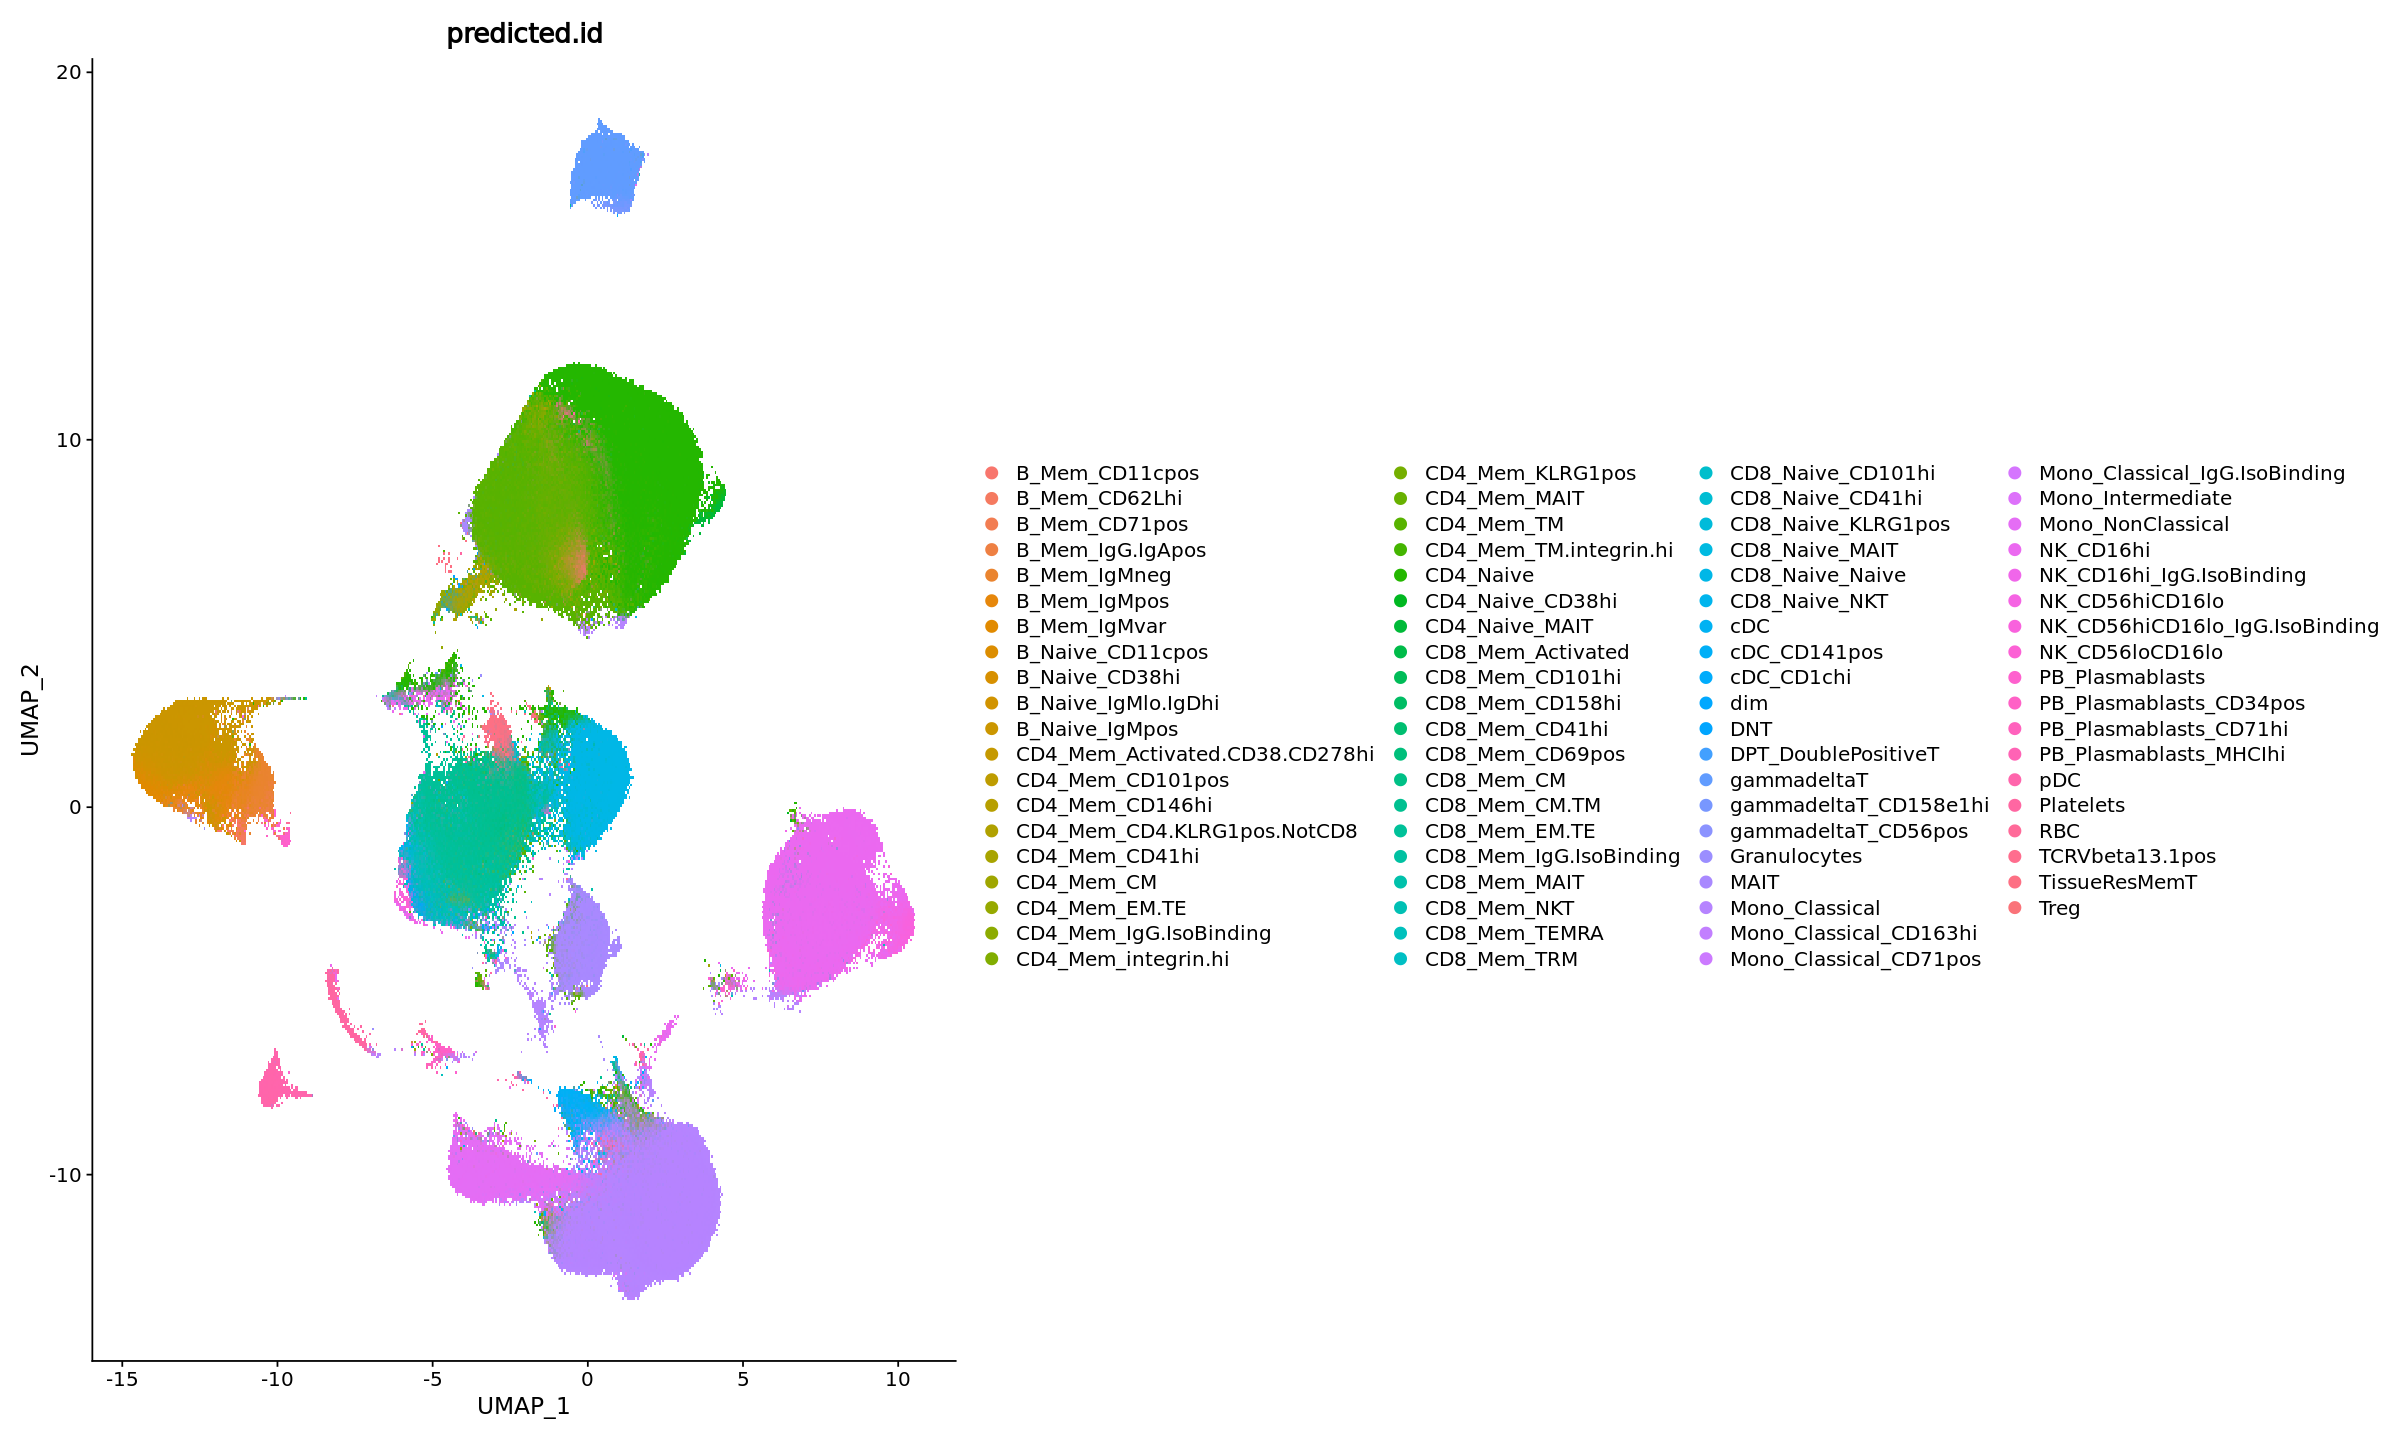

In [42]:
options(repr.plot.width=20, repr.plot.height=12)
DimPlot(covid_flu, reduction = "adt.umap", label=FALSE, raster = TRUE, group.by = "predicted.id")

In [ ]:
## assign the celltypes regarding to the covid-flu names to be able to compare

In [57]:
predictions <- readRDS("labeltransfer_predictions.rds") %>% rownames_to_column("barcode")
predictions_matched <- read.csv("labeltransfer_predictions_id_covidflu_map.csv")

In [58]:
head(predictions)

,barcode,predicted.id,prediction.score.Mono_NonClassical,prediction.score.B_Naive_IgMpos,prediction.score.Mono_Classical,prediction.score.NK_CD16hi,prediction.score.B_Mem_IgMneg,prediction.score.gammadeltaT,prediction.score.Mono_Classical_CD163hi,prediction.score.Mono_Classical_CD71pos,⋯,prediction.score.Mono_Intermediate_clump,prediction.score.CD4_Mem_CD41hi,prediction.score.Mono_Classical_CD1dpos,prediction.score.Mono_NonClassical_IgPos,prediction.score.Mono_Intermediate,prediction.score.CD4_Mem_MAIT,prediction.score.CD4_Mem_CD22hi,prediction.score.cDC_CD141pos,prediction.score.CD4_Mem_CD69pos,prediction.score.max
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Batch1_COVFLU_CITE_multi5P12_ACTGATGGTTCAGCGC-1,Mono_Classical,0.01387509,0.000000,0.9141866,0,0,0,0.02812370,0,⋯,0,0,0,0,0,0,0,0,0,0.9141866
2,Batch1_COVFLU_CITE_multi5P16_CCCAGTTTCGGCTTGG-1,B_Naive_IgMpos,0.00000000,0.552819,0.0000000,0,0,0,0.00000000,0,⋯,0,0,0,0,0,0,0,0,0,0.5528190
3,Batch1_COVFLU_CITE_multi5P09_GCATGCGCAGCCTATA-1,CD4_Naive,0.00000000,0.000000,0.0000000,0,0,0,0.00000000,0,⋯,0,0,0,0,0,0,0,0,0,0.6672915
4,Batch1_COVFLU_CITE_multi5P11_CATCCACAGCTCTCGG-1,Mono_Classical,0.00000000,0.000000,0.9527907,0,0,0,0.01811537,0,⋯,0,0,0,0,0,0,0,0,0,0.9527907
5,Batch1_COVFLU_CITE_multi5P02_TTGTAGGCAGTATCTG-1,CD4_Mem_CM,0.00000000,0.000000,0.0000000,0,0,0,0.00000000,0,⋯,0,0,0,0,0,0,0,0,0,0.5417251
6,Batch1_COVFLU_CITE_multi5P02_GATGCTACAGCTTAAC-1,CD4_Naive,0.00000000,0.000000,0.0000000,0,0,0,0.00000000,0,⋯,0,0,0,0,0,0,0,0,0,0.8819621


In [59]:
predictions_matched$predicted_id_matched[! predictions_matched$predicted_id_matched %in% unique(covid_flu$cell.type)]

[1] "dim" "RBC"

In [60]:
length(unique(predictions$predicted.id))

[1] 78

In [61]:
predictions = left_join(predictions, predictions_matched, by = c("predicted.id" = "predicted_id"))

In [85]:
# add the the "truth" from curated covid-flu annotations
predictions$covid_flu_celltype = covid_flu$cell.type
predictions$covid_flu_celltype = replace(predictions$covid_flu_celltype, predictions$covid_flu_celltype == "B_Naive_Intermediate", "B_Naive")
predictions$covid_flu_coarsecelltype = covid_flu$coarse.cell.type

In [89]:
saveRDS(predictions, "labeltransfer_predictions_wcovidflu_celltype.rds")

In [33]:
sort(unique(covid_flu$cell.type))

[1] "B_Mem"                "B_Naive"              "B_Naive_Intermediate"
 [4] "CD4_CM"               "CD4_EM"               "CD4_Naive"           
 [7] "CD4_platelet_bind"    "CD4_Tfh"              "CD4_Treg"            
[10] "CD8_CM"               "CD8_EM"               "CD8_Naive"           
[13] "CD8_proliferating"    "CD8_TEMRA"            "CD8_TRM"             
[16] "cDC"                  "gdT-Vd2"              "HSPC"                
[19] "ILC"                  "Mac-or-Mono"          "MAIT"                
[22] "Mono_Classical"       "Mono_Intermediate"    "Mono_NonClassical"   
[25] "Mono-T-dblt"          "Neut"                 "NK_CD16hi"           
[28] "NK_CD56hiCD16lo"      "NK_proliferating"     "pDC"                 
[31] "Plasmablast"          "Platelet"

In [86]:
celltype <- data.frame(table(predictions$predicted_id, predictions$covid_flu_celltype)) %>%
  left_join(data.frame(table(predictions$predicted_id)), by = c("Var1")) %>%
  mutate(prct = Freq.x/Freq.y*100) %>%
  reshape2::dcast(Var1 ~ Var2, value.var = "prct") %>%
  column_to_rownames("Var1")

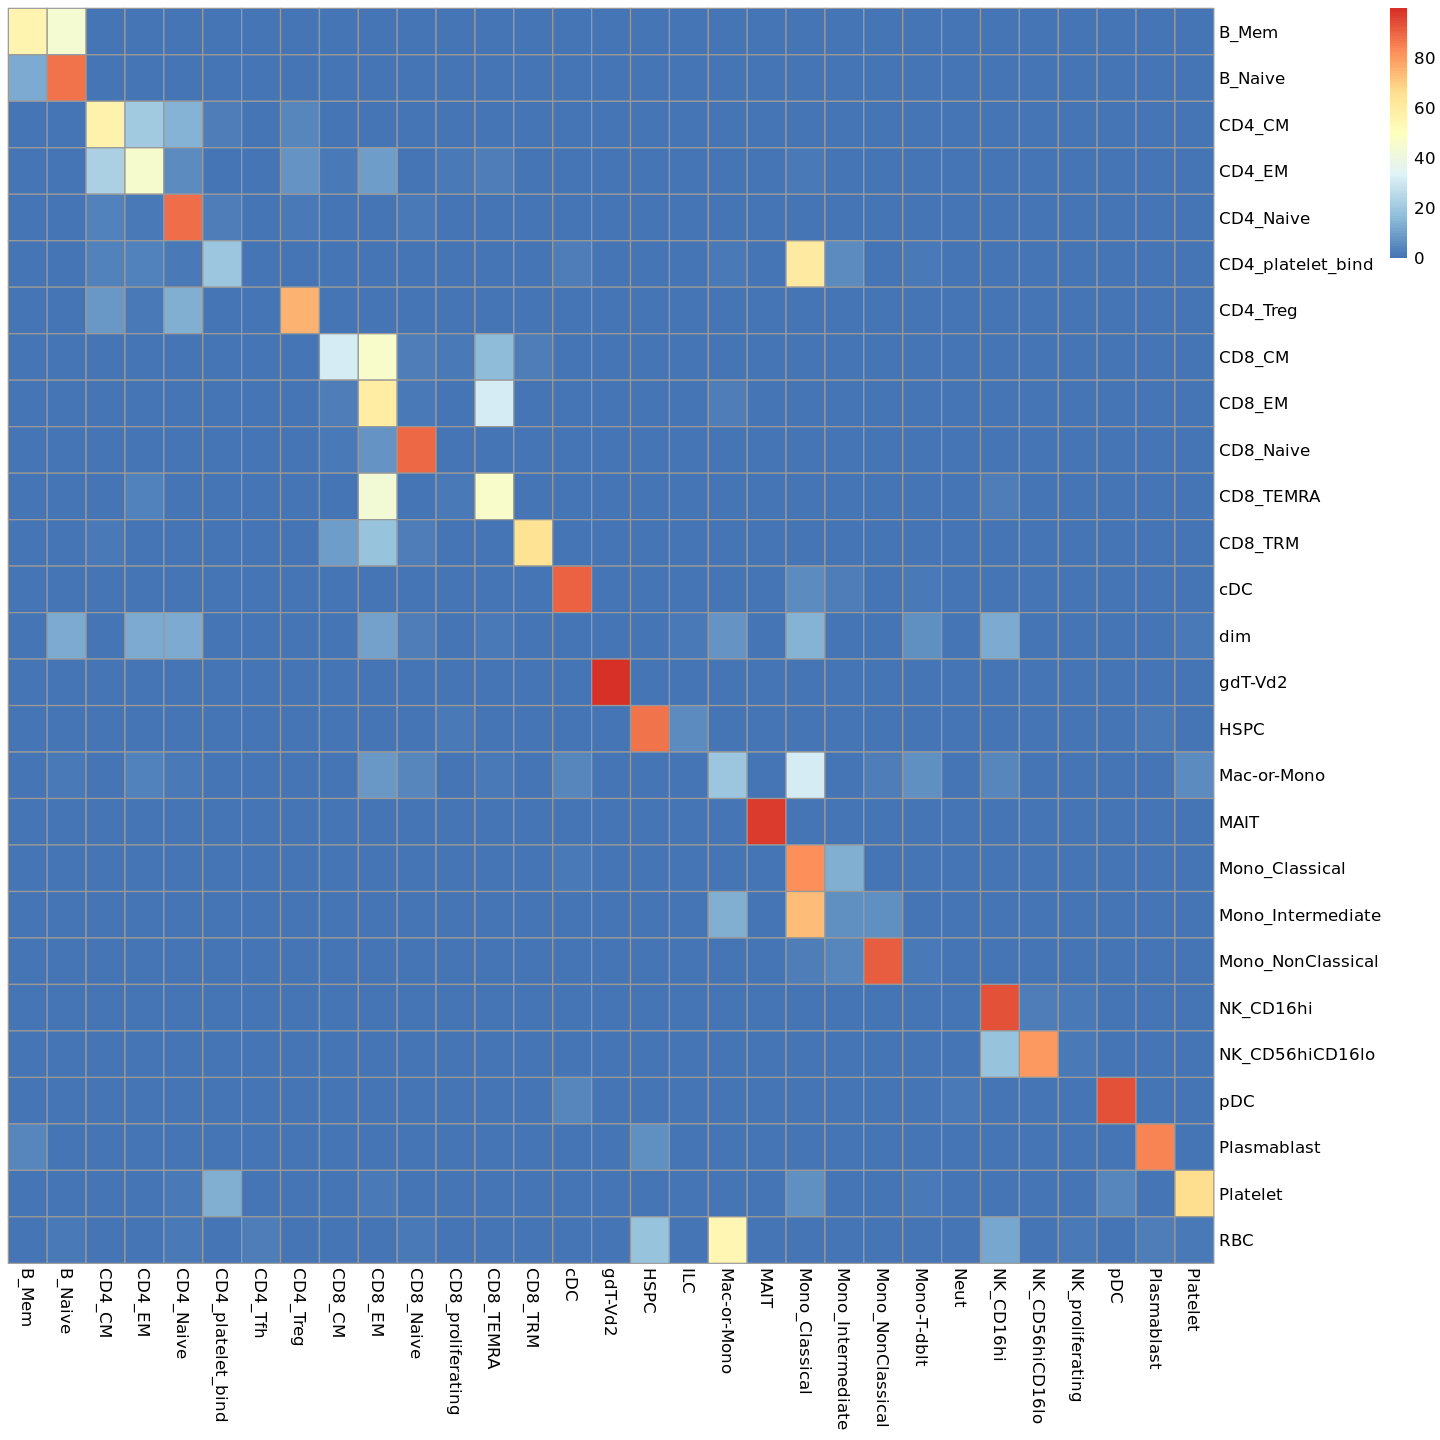

In [87]:
pheatmap(celltype,cluster_rows = FALSE, cluster_cols = FALSE)

In [90]:
head(celltype)

,B_Mem,B_Naive,CD4_CM,CD4_EM,CD4_Naive,CD4_platelet_bind,CD4_Tfh,CD4_Treg,CD8_CM,CD8_EM,⋯,Mono_Intermediate,Mono_NonClassical,Mono-T-dblt,Neut,NK_CD16hi,NK_CD56hiCD16lo,NK_proliferating,pDC,Plasmablast,Platelet
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B_Mem,5.524597e+01,44.371873263,0.000000,0.000000,0.02779322,0.0000000,0.0000000,0.000000,0.00000000,0.000000000,⋯,0.02084491,0.006948305,0.006948305,0.000000000,0.000000000,0.0000000000,0.0000000,0,0.21539744,0
B_Naive,1.239321e+01,87.585697711,0.000000,0.000000,0.00000000,0.0000000,0.0000000,0.000000,0.00000000,0.003515804,⋯,0.00000000,0.000000000,0.000000000,0.003515804,0.000000000,0.0000000000,0.0000000,0,0.01054741,0
CD4_CM,0.000000e+00,0.001090441,56.264585,20.164439,14.58792227,2.4393169,0.0686978,4.146948,0.13085294,0.214816915,⋯,0.05779338,0.007633088,0.375111770,0.121038972,0.020718383,0.0000000000,0.0000000,0,0.00000000,0
CD4_EM,0.000000e+00,0.000000000,21.992819,45.436864,5.01196888,0.7779773,0.3291442,7.809695,1.06223818,8.991621783,⋯,0.26929982,0.164572113,0.598444045,0.269299820,0.074805506,0.0000000000,0.0149611,0,0.00000000,0
CD4_Naive,9.135841e-04,0.021012434,3.925671,1.001288,87.92515919,2.3981582,0.7865959,1.008597,0.08222257,0.191852657,⋯,0.01096301,0.007308673,0.274988809,0.137951196,0.009135841,0.0009135841,0.0000000,0,0.00000000,0
CD4_platelet_bind,0.000000e+00,0.000000000,3.267974,3.921569,1.96078431,18.9542484,0.0000000,0.000000,0.00000000,0.653594771,⋯,5.22875817,0.000000000,1.960784314,0.000000000,0.000000000,0.0000000000,0.0000000,0,0.00000000,0
